In [15]:
from models.model import ImagenTime # \models\model.py
from utils.utils_data import gen_dataloader
from utils.utils import restore_state
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from models.sampler import DiffusionProcess
%matplotlib inline
import torch


In [16]:

# Define args as needed for gen_dataloader
class Args:
	def __init__(self):
		self.batch_size = 140
		# self.seq_len = 24
		self.use_stft = False
		self.delay = 8
		self.embedding = 32
		self.img_resolution = 32
		self.input_channels = 28
		self.unet_channels = 128
		self.ch_mult = [1,2,2,4]
		self.attn_resolution = [8,4,2]
		self.diffusion_steps = 18
		self.ema = True
		self.ema_warmup = 100
		self.logging_iter = 100
		self.dataset = 'fmri'
		self.device = 'cuda'
		self.num_workers = 4


args = Args()

train_loader, test_loader = gen_dataloader(args)
print("dataset ready")

./data/short_range/padded_fmri_set.pt
dataset ready


In [17]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

model = ImagenTime(args=args, device=args.device).to(args.device)
if args.use_stft:
    model.init_stft_embedder(train_loader)
    print("STFT embedder initialized")

args.learning_rate=  0.0003 #1e-4
args.weight_decay=  0.00001 #1e-4
args.resume = False
args.epochs = 1000
args.beta1 = 1e-05
args.betaT = 0.01
args.deterministic = False


optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
state = dict(model=model, epoch=0)
init_epoch = 0


if args.resume:
    ema_model = model.model_ema if args.ema else None # load ema model if available
    init_epoch = restore_state(args, state, ema_model=ema_model)

x_ts shape:  torch.Size([140, 264, 1])
True
torch.Size([140, 1, 32, 32])


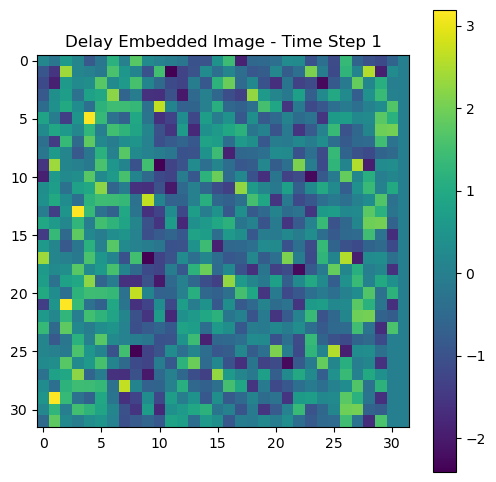

In [18]:
for i, data in enumerate(train_loader, 1):
    x_ts = data[0].to(args.device)
    print("x_ts shape: ", x_ts.shape)

    x_img = model.ts_to_img(x_ts)
    print(x_img.shape)

    
    x_img_np = x_img.cpu().detach().numpy()  # Convert to NumPy 

    time_step = 0  # Change this index to view different samples
    image = x_img_np[time_step, 0, :, :]  # shape: time step, 1, img res, img res

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='viridis')  # Use color map 
    plt.colorbar()  #  a color bar to interpret values
    plt.title(f"Delay Embedded Image - Time Step {time_step + 1}")
    # plt.xlabel("Time Lag")
    # plt.ylabel("Embedding Dimension")
    plt.savefig("delay_embedded_image_ts1.png")
    plt.show()

    break



In [21]:
After_trans_ts = model.img_to_ts(x_img)

print(After_trans_ts.shape)

torch.Size([140, 264, 1])


In [27]:
Bf_transform_ts = x_ts
After_trans_ts = After_trans_ts


print(f"Before Transformation ts_shape: {Bf_transform_ts.shape}")
print(f"After Transformation ts_shape: {After_trans_ts.shape}")
print("\n")


Bf_transform_ts_flat = Bf_transform_ts.view(-1)
After_trans_ts_flat = After_trans_ts.view(-1)

# Calculate MAE (Mean Absolute Error)
mae = torch.mean(torch.abs(Bf_transform_ts_flat - After_trans_ts_flat))

# Calculate MRSE (Mean Root Squared Error)
mrse = torch.sqrt(torch.mean((Bf_transform_ts_flat - After_trans_ts_flat) ** 2))

print(f"MAE: {mae.item()}")
print(f"MRSE: {mrse.item()}")

Before Transformation ts_shape: torch.Size([140, 264, 1])
After Transformation ts_shape: torch.Size([140, 264, 1])


MAE: 0.0
MRSE: 0.0
